In [23]:
import re
from string import punctuation

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pymystem3 import Mystem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from gensim.models import word2vec
from sklearn.base import BaseEstimator, TransformerMixin

RANDOM_STATE = 41825352
DATASET_URL = '../data/cbr-press-releases.csv'

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
df = pd.read_csv(DATASET_URL, parse_dates=['date'])
df['rate'] = df.rate.shift(1)
df.loc[0, 'rate'] = 5.5
df.set_index('date', inplace=True)
df.drop('link', axis=1, inplace=True)
df.sort_values('date', inplace=True)
cur_pr = df.tail(1)
df = df[:-1]
X = df.drop(['target_categorial', 'target_absolute', 'target_relative'], axis=1)
y = df['target_categorial']

In [25]:
y_pred = y.shift(1)
accuracy = accuracy_score(y[1:], y_pred[1:])
f1 = f1_score(y[1:], y_pred[1:], average='macro')
precision = precision_score(y[1:], y_pred[1:], average='macro')
recall = recall_score(y[1:], y_pred[1:], average='macro')
min_baseline = pd.DataFrame({'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}, index=['min_baseline'])

In [26]:
def calc_metrics_on_lr(X, model, *, name, plot=True, **params):
    y_preds = []
    y_preds_proba = []
    model = model(**params)
    for threshold in range(30, 96):
        X_train = X[:threshold]
        X_test = X[threshold:]
        y_train = y[:threshold]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test[0].reshape(1, -1))
        y_pred_proba = model.predict_proba(X_test[0].reshape(1, -1))
        y_preds.append(y_pred.item())
        y_preds_proba.append(y_pred_proba)

    acc = accuracy_score(y[30:], y_preds)
    f1 = f1_score(y[30:], y_preds, average='macro')
    recall = recall_score(y[30:], y_preds, average='macro')
    precision = precision_score(y[30:], y_preds, average='macro')
    roc_auc = roc_auc_score(y[30:], np.concatenate(y_preds_proba, axis=0), average='macro', multi_class='ovr')
    if plot:
        print(classification_report(y[30:], y_preds))
        cm = confusion_matrix(y[30:], y_preds)
        cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', 1])
        plt.figure(figsize=(3, 3))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title("Confusion matrix")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        metrics = pd.DataFrame({
            'accuracy': acc, 'f1': f1, 'recall': recall, 'precision': precision, 'roc_auc_ovr': roc_auc,
            }, index=[name])
        return metrics, model
    else:
        return roc_auc.item(), model

In [ ]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, *, preprocessor=None, vector_size=50, window=3, workers=4):
        self._preprocessor = preprocessor
        self._vector_size = vector_size
        self._window = window
        self._workers = workers
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self._preprocessor:
            X = X.apply(self._preprocessor).tolist()
        
        self.model = word2vec.Word2Vec(
            X, vector_size=self._vector_size,
            window=self._window, workers=self._workers,
            seed=RANDOM_STATE
        )
    
        return np.array([
            np.mean([self.model.wv[w] for w in words if w in self.model.wv] 
                    or [np.zeros(self.model.vector_size)], axis=0)
            for words in X
        ])

In [238]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё0-9]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    return [word for word in text.split() if word not in STOP_WORDS and len(word) > 3]

vectorizer = Word2VecVectorizer(
    preprocessor=preprocessor,
    vector_size=200,
    workers=8,
    window=1
)

vectorizer.fit(X.release)

w2vec = vectorizer.transform(X.release)

scaler = StandardScaler()
w2vec = scaler.fit_transform(w2vec)

m = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
m.fit(w2vec, y)
accuracy_score(y, m.predict(w2vec))


0.8229166666666666

In [239]:
auc = []
for c in tqdm(np.linspace(0.001, 10, 30)):
    auc.append(calc_metrics_on_lr(w2vec, LogisticRegression, name='w2v l1 only release', plot=False,
                                  max_iter=10000, solver='liblinear', penalty='l1', C=c.item(), random_state=RANDOM_STATE))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 30/30 [00:24<00:00,  1.23it/s]

Лучшая модель - LogisticRegression(C=5.172896551724139, max_iter=10000, penalty='l1',
                   random_state=41825352, solver='liblinear')
ROC-AUC = 0.6776543405378849


              precision    recall  f1-score   support

        -1.0       0.58      0.61      0.60        23
         0.0       0.38      0.38      0.38        24
         1.0       0.61      0.58      0.59        19

    accuracy                           0.52        66
   macro avg       0.52      0.52      0.52        66
weighted avg       0.52      0.52      0.52        66



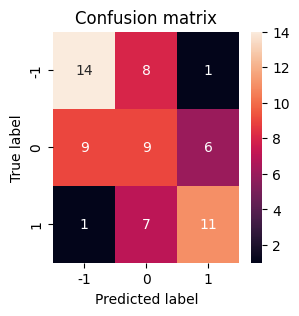

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
word2vec l1 only release,0.515152,0.521780,0.523148,0.520881,0.677654


In [240]:
metric, model = calc_metrics_on_lr(w2vec, LogisticRegression, name='word2vec l1 only release', **best_model.get_params())
metrics = pd.concat([min_baseline, metric], axis=0)
metrics